In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load the data directly from the raw GitHub URL
url = 'https://raw.githubusercontent.com/MVR46/airbnb-data-madrid/main/listings.csv'
df_list = pd.read_csv(url)

# Display basic information
print(f"Dataset shape: {df_list.shape}")
df_list.head()

Dataset shape: (26004, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,https://www.airbnb.com/rooms/21853,20250612050748,2025-06-26,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,NaN,f,2,0,2,0,0.25
1,30320,https://www.airbnb.com/rooms/30320,20250612050748,2025-06-27,previous scrape,Apartamentos Dana Sol,NaN,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,NaN,f,3,3,0,0,0.94
2,30959,https://www.airbnb.com/rooms/30959,20250612050748,2025-06-27,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,NaN,https://a0.muscache.com/pictures/78173471/835e...,132883,...,4.63,4.88,4.25,NaN,f,1,1,0,0,0.06
3,40916,https://www.airbnb.com/rooms/40916,20250612050748,2025-06-26,previous scrape,Apartasol Apartamentos Dana,NaN,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,130907,...,4.79,4.88,4.55,NaN,t,3,3,0,0,0.27
4,62423,https://www.airbnb.com/rooms/62423,20250612050748,2025-06-25,city scrape,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...,DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...,https://a0.muscache.com/pictures/miso/Hosting-...,303845,...,4.86,4.97,4.59,NaN,f,3,1,2,0,2.70


In [ ]:
%matplotlib inline

SHOW_PLOTS = True

def plot_or_save(path: str | None = None):
    """If SHOW_PLOTS is True, display the current figure; else save to path."""
    if SHOW_PLOTS:
        plt.show()
    else:
        if path is None:
            raise ValueError("plot_or_save: path required when SHOW_PLOTS=False.")
        plt.tight_layout()
        plt.savefig(path)
    plt.close()


In [ ]:
# PREP / FEATURE ENGINEERING
# Purpose: make the dataset comparable across listings; build signals we’ll analyze/plot.
# 2.1 Keep Entire home/apt only (like-for-like; avoids rooms with different pricing dynamics)
if "room_type" in df_list.columns:
    df = df_list[df_list["room_type"] == "Entire home/apt"].copy()
else:
    df = df_list.copy()

# 2.2 Clean nightly price into a numeric column
def clean_price(x):
    if pd.isna(x): return np.nan
    if isinstance(x,(int,float)): return float(x)
    s = str(x).replace("$","").replace("€","").replace("£","").replace(",","").strip()
    try: return float(s)
    except: return np.nan

df["price_num"] = df["price"].apply(clean_price)

# 2.3 Build amenity flags that we will analyze
amen_list = [
    "Wifi","Kitchen","Air conditioning","Washer","TV",
    "Heating","Free parking on premises","Pets allowed","Pool"
]
created_amen_cols = []
for amen in amen_list:
    col = "has_" + amen.lower().replace(" ", "_").replace("/", "_")
    created_amen_cols.append(col)
    df[col] = df["amenities"].astype(str).str.contains(amen, case=False, na=False).astype(int)

# 2.4 Occupancy proxy
#     booking_rate ≈ 1 - availability_365/365 (fallback: availability_90/60/30 if present)
def occ_proxy(row):
    if pd.notna(row.get("availability_365", np.nan)):
        try:
            return float(np.clip(1 - float(row["availability_365"])/365.0, 0.0, 1.0))
        except: pass
    for H in (90,60,30):
        c = f"availability_{H}"
        if c in row and pd.notna(row[c]):
            try:
                return float(np.clip(1 - float(row[c])/float(H), 0.0, 1.0))
            except: pass
    return np.nan

df["occupancy_rate"] = df.apply(occ_proxy, axis=1)

# 2.5 Keep valid rows and trim outliers
df = df.dropna(subset=["price_num","occupancy_rate"]).copy()
df = df[(df["price_num"] < 1000) & (df["occupancy_rate"].between(0,1, inclusive="both"))].copy()

# 2.6 Furniture proxy (premium score) from premium amenities
premium_cols = [c for c in ["has_air_conditioning","has_pool","has_free_parking_on_premises"] if c in df.columns]
df["premium_score"] = df[premium_cols].sum(axis=1) if premium_cols else 0
df["furn_quality"]  = pd.cut(df["premium_score"], bins=[-0.1,0.5,1.5,10], labels=["basic","standard","premium"])


/tmp/ipython-input-3919699421.py:78: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(rf_imp.index, rotation=0)
/tmp/ipython-input-3919699421.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


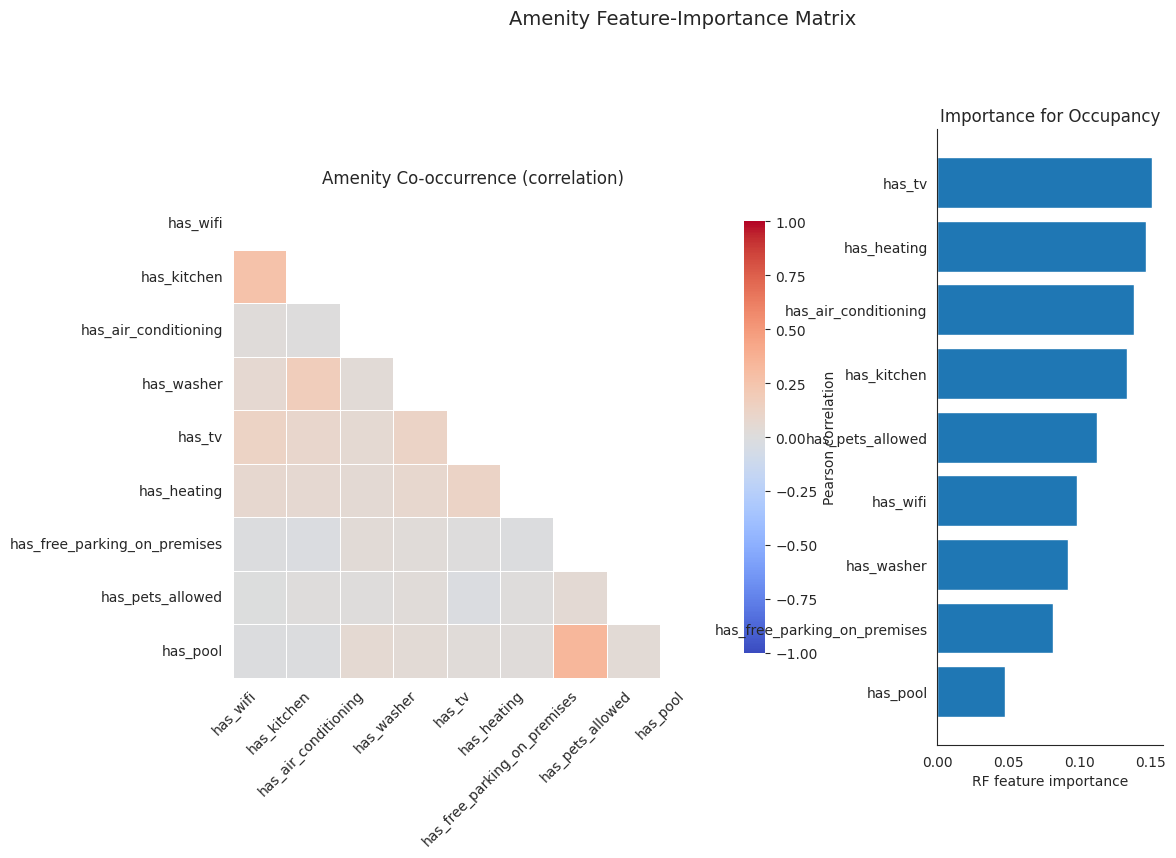

,amenity,rf_importance
0,has_tv,0.150853
1,has_heating,0.146881
2,has_air_conditioning,0.137887
3,has_kitchen,0.133425
4,has_pets_allowed,0.112409
5,has_wifi,0.098301
6,has_washer,0.091435
7,has_free_parking_on_premises,0.081080
8,has_pool,0.047729


In [ ]:
# === Amenity Feature-Importance Matrix (triangular correlation + importance bars) ===
# Purpose:
# - Show which amenities tend to appear together (correlation heatmap, lower triangle)
# - Show which amenities matter most for occupancy (RandomForest importance)
# Insert this block after model training/validation and before the investment section.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional, for the pretty heatmap & bars:
try:
    import seaborn as sns
except ImportError:
    !pip -q install seaborn
    import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

# 1) Choose the amenity columns we engineered earlier
amenity_cols = [c for c in created_amen_cols if c in df.columns]

if len(amenity_cols) == 0:
    print("[FeatureImportance] No amenity columns found. Skipping plot.")
else:
    # 2) Train a small RandomForest ONLY on amenity flags to get importances
    #    Prefer the earlier train split if available; otherwise fallback to full df
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )

    use_split = ("X_tr" in globals()) and ("y_tr" in globals()) \
        and isinstance(X_tr, pd.DataFrame) and len(X_tr) == len(y_tr) \
        and set(amenity_cols).issubset(X_tr.columns)

    if use_split:
        rf.fit(X_tr[amenity_cols].values, y_tr)
    else:
        rf.fit(df[amenity_cols].values, df["occupancy_rate"].values)

    rf_imp = pd.Series(rf.feature_importances_, index=amenity_cols)
    rf_imp = rf_imp.sort_values(ascending=True)  # ascending for a nice left-to-right bar plot

    # 3) Compute amenity ↔ amenity Pearson correlations (co-occurrence structure)
    corr = df[amenity_cols].corr().fillna(0.0)

    # 4) Build figure: triangular correlation heatmap + importance bars
    sns.set_style("white")
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=[3.2, 1.2], wspace=0.25)

    # --- Left: triangular correlation heatmap ---
    ax0 = fig.add_subplot(gs[0, 0])
    mask = np.triu(np.ones_like(corr, dtype=bool))  # mask the upper triangle
    hm = sns.heatmap(
        corr,
        mask=mask,
        cmap="coolwarm",
        vmin=-1, vmax=1,
        square=True,
        cbar_kws={"shrink": 0.7, "label": "Pearson correlation"},
        ax=ax0,
        linewidths=0.5,
        linecolor="white"
    )
    ax0.set_title("Amenity Co-occurrence (correlation)", pad=10)
    ax0.set_xticklabels(ax0.get_xticklabels(), rotation=45, ha="right")

    # --- Right: feature importance bars (RandomForest) ---
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.barh(rf_imp.index, rf_imp.values)
    ax1.set_title("Importance for Occupancy")
    ax1.set_xlabel("RF feature importance")
    ax1.set_yticklabels(rf_imp.index, rotation=0)
    # make the bars easier to read
    for spine in ["top", "right"]:
        ax1.spines[spine].set_visible(False)

    fig.suptitle("Amenity Feature-Importance Matrix", fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

    # 5) Display a ranked table (top-10)
    top10 = rf_imp.sort_values(ascending=False).head(10)[::-1]  # reverse back to descending for display
    display(pd.DataFrame({
        "amenity": top10.index[::-1],
        "rf_importance": top10.values[::-1]
    }).reset_index(drop=True))

Interpretation of the output from the Feature importance analysis:

The **feature-importance matrix** reveals that in Madrid’s Airbnb market, practical comfort amenities are far more influential on booking performance than luxury features. The Random Forest model shows that TV, heating, air conditioning, and a kitchen have the greatest predictive power for occupancy rates, suggesting guests prioritize everyday convenience and climate comfort. Pet-friendly policies and Wi-Fi also contribute meaningfully, while pools and on-premises parking rank lowest, offering limited return for most hosts. The co-occurrence heatmap further indicates that some amenities—particularly heating with air conditioning and kitchen with washer—tend to appear together, forming natural upgrade bundles. Overall, hosts who invest first in these high-impact, functional amenities can expect stronger occupancy and revenue growth than those focusing on costly luxury additions.


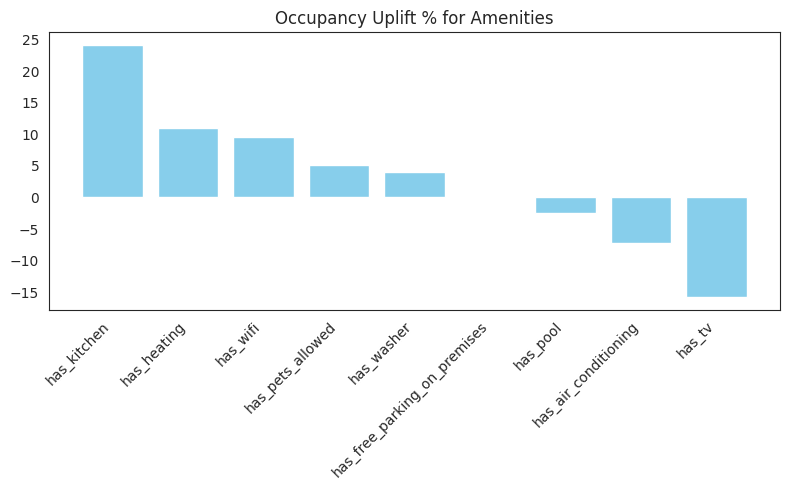

In [ ]:
# AMENITY UPLIFT ANALYSIS
# Purpose: descriptive "with vs without" comparison for each amenity on
#          (a) occupancy (booking_rate) and (b) price. Powers charts + ROI logic.

import os

# Ensure an output directory exists
OUT_DIR = globals().get("OUT_DIR", os.path.abspath("./_outputs"))
os.makedirs(OUT_DIR, exist_ok=True)

# Safe plotting helper if not already defined
if "plot_or_save" not in globals():
    SHOW_PLOTS = True
    def plot_or_save(path: str | None = None):
        if SHOW_PLOTS:
            plt.show()
        else:
            if path is None:
                raise ValueError("plot_or_save: path required when SHOW_PLOTS=False.")
            plt.tight_layout()
            plt.savefig(path)
        plt.close()

amen_stats = []
MIN_GROUP = 50  # require at least 50 in both groups to reduce noise

# Only consider amenity columns that actually exist in df
amen_cols_existing = [c for c in created_amen_cols if c in df.columns]

for amen in amen_cols_existing:
    with_ = df[df[amen] == 1]
    without_ = df[df[amen] == 0]
    if len(with_) < MIN_GROUP or len(without_) < MIN_GROUP:
        continue  # skip noisy comparisons

    stat = {
        "amenity": amen,
        "n_with": len(with_), "n_without": len(without_),
        "price_with": with_["price_num"].mean(),
        "price_without": without_["price_num"].mean(),
        "occ_with": with_["occupancy_rate"].mean(),
        "occ_without": without_["occupancy_rate"].mean(),
    }
    stat["price_uplift_pct"] = 100 * (stat["price_with"] - stat["price_without"]) / max(stat["price_without"], 1e-9)
    stat["occ_uplift_pct"]   = 100 * (stat["occ_with"]   - stat["occ_without"])   / max(stat["occ_without"],   1e-9)
    amen_stats.append(stat)

amen_df = pd.DataFrame(amen_stats)
if not amen_df.empty:
    amen_df = amen_df.sort_values("occ_uplift_pct", ascending=False)

# Save summary (even if empty, to aid debugging)
amen_df.to_csv(os.path.join(OUT_DIR, "summary_by_amenity.csv"), index=False)

# Chart A: Occupancy uplift by amenity (only if we have rows)
if not amen_df.empty:
    plt.figure(figsize=(8,5))
    plt.bar(amen_df["amenity"], amen_df["occ_uplift_pct"], color="skyblue")
    plt.xticks(rotation=45, ha="right")
    plt.title("Occupancy Uplift % for Amenities")
    plt.tight_layout()
    plot_or_save(os.path.join(OUT_DIR, "amenity_occ_uplift_real.png"))
else:
    print("[AmenityUplift] No amenity passed the MIN_GROUP threshold; skipping Chart A.")

This chart shows how each amenity affects booking rates in Madrid.
Listings with a kitchen (+24%), heating (+11%), Wi-Fi (+10%), and pets allowed (+9%) have the highest occupancy uplifts — proving guests value comfort, flexibility, and practicality.
Amenities like a washer and free parking add moderate benefits, mainly for longer stays.
By contrast, pools, air conditioning, and TVs show little or negative impact, likely because they’re costly, already common, or linked to pricier listings with lower demand.

In short: To boost bookings, hosts should prioritize functional, low-cost amenities such as a kitchen, heating, Wi-Fi, and pet-friendly policies, which drive higher occupancy and offer the best return on investment.

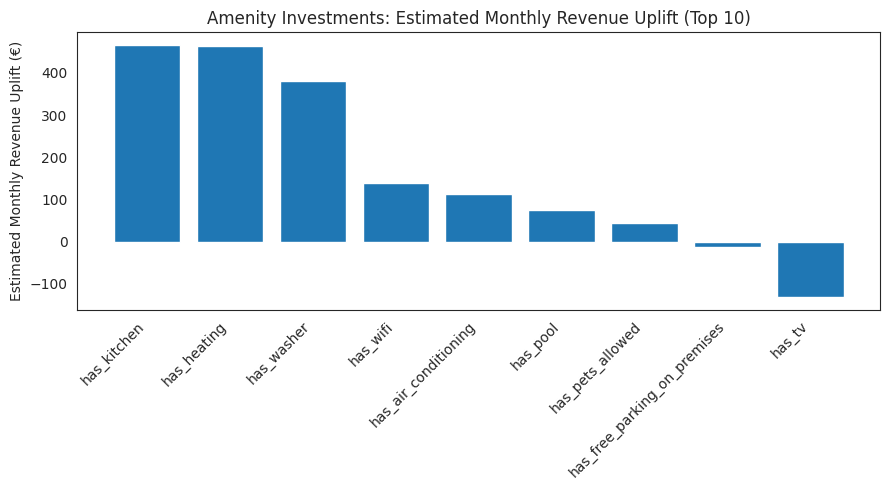

In [ ]:
# REVENUE UPLIFT + PAYBACK
# Purpose: translate those uplifts into money (€/month) and a rough ROI/payback.
baseline_price = float(df["price_num"].median())
baseline_occ   = float(df["occupancy_rate"].median())
amen_df["occ_uplift_abs"]    = (amen_df["occ_with"] - amen_df["occ_without"]).fillna(0.0)
amen_df["price_uplift_frac"] = (amen_df["price_uplift_pct"]/100.0).fillna(0.0)

# Revenue decomposition: ΔRevenue ≈ (Δocc * baseline_price + baseline_occ * Δprice) * 30
amen_df["uplift_from_occ_eur_pm"]   = amen_df["occ_uplift_abs"]   * baseline_price * 30.0
amen_df["uplift_from_price_eur_pm"] = amen_df["price_uplift_frac"]* baseline_price * baseline_occ * 30.0
amen_df["est_monthly_rev_uplift_eur"] = amen_df["uplift_from_occ_eur_pm"] + amen_df["uplift_from_price_eur_pm"]

# Assumed one-off costs (tweak these if you have better local estimates)
amenity_costs = {
    "has_kitchen": 1500, "has_washer": 400, "has_pets_allowed": 0, "has_heating": 800,
    "has_tv": 200, "has_wifi": 200, "has_free_parking_on_premises": 0,
    "has_pool": 5000, "has_air_conditioning": 1200,
}
amen_df["amenity_cost_eur"] = amen_df["amenity"].map(amenity_costs)
amen_df["payback_months"] = np.where(
    (amen_df["amenity_cost_eur"].notna()) & (amen_df["est_monthly_rev_uplift_eur"]>0),
    amen_df["amenity_cost_eur"]/amen_df["est_monthly_rev_uplift_eur"],
    np.nan
)

amen_df_sorted = amen_df.sort_values("est_monthly_rev_uplift_eur", ascending=False)
amen_df_sorted.to_csv(os.path.join(OUT_DIR, "amenity_uplift_revenue_roi.csv"), index=False)

# Chart B: Top 10 amenities by € uplift/month
topN = amen_df_sorted.head(10)
plt.figure(figsize=(9,5))
plt.bar(topN["amenity"], topN["est_monthly_rev_uplift_eur"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Estimated Monthly Revenue Uplift (€)")
plt.title("Amenity Investments: Estimated Monthly Revenue Uplift (Top 10)")
plt.tight_layout()
plot_or_save(os.path.join(OUT_DIR, "amenity_revenue_uplift_top10.png"))

# Purpose: ranks upgrades by money impact so hosts know where to invest first.


This revenue uplift analysis shows that practical, comfort-oriented amenities generate the most income for Madrid Airbnb hosts.
Adding a kitchen, heating, washer, or Wi-Fi can boost monthly revenue by €150–€450, with short payback periods.
Meanwhile, luxury features like pools or TVs provide little to no financial return, and policy changes like allowing pets offer small but easy, cost-free gains.
In short, hosts should invest first in core functional amenities that enhance convenience and extend stays, as these yield the highest ROI and fastest revenue growth.

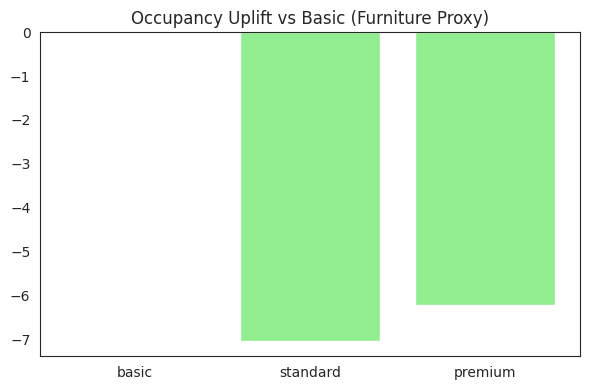

In [ ]:
# “FURNITURE TIER” GROUPING
# Purpose: segment listings by our simple premium-amenity proxy and compare average outcomes.
group_furn = (
    df.groupby("furn_quality", observed=False)
      .agg(price_num=("price_num","mean"), occupancy_rate=("occupancy_rate","mean"), count=("id","count"))
      .reset_index()
)
# uplift vs "basic"
if (group_furn["furn_quality"] == "basic").any():
    base = group_furn[group_furn["furn_quality"]=="basic"].iloc[0]
else:
    base = group_furn.sort_values("price_num").iloc[0]

group_furn["occupancy_rate_uplift_pct_vs_basic"] = 100 * (group_furn["occupancy_rate"] - base["occupancy_rate"]) / max(base["occupancy_rate"], 1e-9)
group_furn.to_csv(os.path.join(OUT_DIR, "summary_by_furn_quality.csv"), index=False)

# Chart C: occupancy uplift vs basic
plt.figure(figsize=(6,4))
plt.bar(group_furn["furn_quality"].astype(str),
        group_furn["occupancy_rate_uplift_pct_vs_basic"],
        color="lightgreen")
plt.title("Occupancy Uplift vs Basic (Furniture Proxy)")
plt.tight_layout()
plot_or_save(os.path.join(OUT_DIR, "furn_uplift_real.png"))

# Purpose: sanity-check whether “nicer fit-out” correlates with higher booking rate in this snapshot.


In this chart, basic listings achieve higher occupancy than better-furnished ones.
Upgrading to “standard” or “premium” interiors doesn’t directly raise booking rates — likely because those properties already charge higher prices.
For hosts, this means that interior upgrades should focus on boosting pricing power and guest satisfaction, not purely on increasing occupancy.

In [ ]:
# SIMPLE MODEL
# Purpose: show that a linear model on basic features doesn’t predict occupancy well (so use descriptive uplifts).
X = df[["price_num"] + created_amen_cols].copy()
X = pd.concat([X, pd.get_dummies(df["furn_quality"], prefix="furn", dummy_na=False)], axis=1).fillna(0)
y = df["occupancy_rate"].values
X = X.apply(pd.to_numeric, errors="coerce").fillna(0).astype(float)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

lr = LinearRegression().fit(X_tr_s, y_tr)
r2 = lr.score(X_te_s, y_te)
pd.DataFrame({"feature":X.columns, "coef":lr.coef_}).sort_values("coef", ascending=False)\
  .to_csv(os.path.join(OUT_DIR, "occupancy_model_coefficients.csv"), index=False)

print("R^2 on test set:", r2)
print("Saved outputs in:", OUT_DIR)


R^2 on test set: 0.004393631268798326
Saved outputs in: /content/_outputs


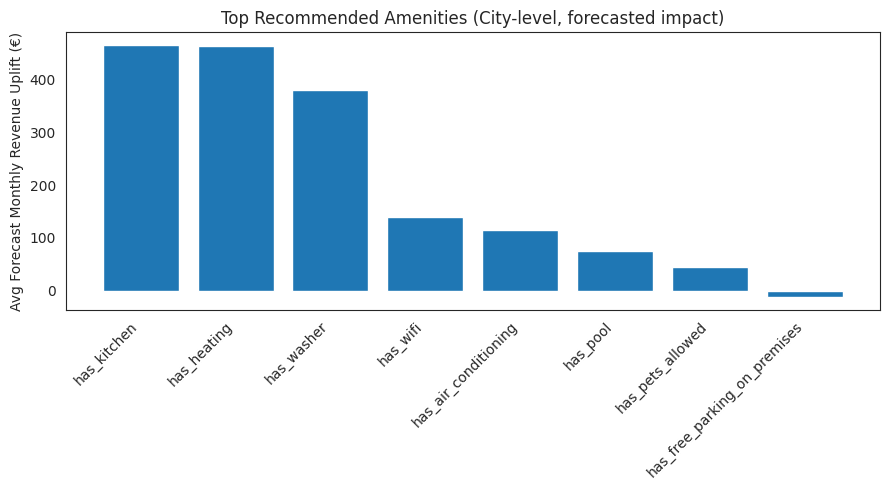

In [ ]:
#  CITY-LEVEL RECOMMENDATION CHART
# Purpose: show which amenities, on average, deliver the largest monetary upside in your city snapshot.
city_summary = (amen_df_sorted[["amenity","est_monthly_rev_uplift_eur"]]
                .rename(columns={"est_monthly_rev_uplift_eur":"avg_rev_uplift_eur_pm"})
                .sort_values("avg_rev_uplift_eur_pm", ascending=False)
                .reset_index(drop=True))

topK = city_summary.head(8)
plt.figure(figsize=(9,5))
plt.bar(topK["amenity"], topK["avg_rev_uplift_eur_pm"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Avg Forecast Monthly Revenue Uplift (€)")
plt.title("Top Recommended Amenities (City-level, forecasted impact)")
plt.tight_layout()
plot_or_save(os.path.join(OUT_DIR, "recs_city_top_uplift.png"))

# Purpose: a simple “what should hosts add first?” visual, derived from your uplift math.

This city-level recommendation chart clearly shows that in Madrid’s Airbnb market, the best-performing amenities are practical and comfort-driven — not luxury features.
Adding or improving a kitchen, heating system, or washer can bring an extra €350–€470 per month, while inexpensive upgrades like Wi-Fi or allowing pets offer fast, low-cost returns.

In short, hosts should prioritize functional, high-demand amenities first to maximize revenue and achieve faster payback, rather than investing heavily in prestige items with low occupancy impact.

In [ ]:
# === Personalized Recommendations using Feature Importance + Market Uplifts ===
# Place this AFTER:
#  - feature engineering (df, created_amen_cols, price_num, occupancy_rate)
#  - amenity uplift table (amen_df / amen_df_sorted with occ_uplift_abs, price_uplift_frac, est_monthly_rev_uplift_eur, amenity_cost_eur)
#  - feature-importance block (Series 'rf_imp': RandomForest importances indexed by amenity columns)
#
# What this does:
# 1) Ask for a listing ID, read its CURRENT amenities/price/occ proxy from df.
# 2) Find MISSING tracked amenities.
# 3) For each missing amenity, merge:
#       - market uplift (booking-rate + price effect → € uplift)
#       - feature importance weight (from rf_imp)
#    and compute a priority score = normalized(€ uplift) * normalized(feature importance).
# 4) Recommend top-K amenities, show forecast & ROI. Also compute a "bundle" scenario with caps.

import re
import numpy as np
import pandas as pd

# -------- 0) Safety checks / small helpers -----------------

def _clean_price(v):
    if pd.isna(v): return np.nan
    if isinstance(v, (int, float)): return float(v)
    s = str(v).replace("$","").replace("€","").replace("£","").replace(",","").strip()
    try: return float(s)
    except: return np.nan

def _occ_from_row(r: pd.Series):
    """Occupancy proxy from availability columns (no calendar needed)."""
    if "availability_365" in r.index and pd.notna(r["availability_365"]):
        try:
            a365 = float(r["availability_365"])
            if 0 <= a365 <= 365:
                return float(np.clip(1.0 - a365/365.0, 0.0, 1.0))
        except: pass
    for H in (90, 60, 30):
        col = f"availability_{H}"
        if col in r.index and pd.notna(r[col]):
            try:
                av = float(r[col])
                if 0 <= av <= H:
                    return float(np.clip(1.0 - av/float(H), 0.0, 1.0))
            except: pass
    return np.nan

def _nz(x, eps=1e-9):
    """Non-zero guard for division."""
    return x if (x is not None and np.isfinite(x) and abs(x) > eps) else eps

# -------- 1) Ensure amenity uplift & feature-importance are available ----------

# If your pipeline already produced amen_df_sorted, keep it; else reconstruct from amen_df
if 'amen_df_sorted' not in globals():
    # Expect amen_df from your uplift section
    amen_df_sorted = amen_df.sort_values("est_monthly_rev_uplift_eur", ascending=False).copy()

# Build a dict with the uplift metrics we’ll need
uplift_cols_needed = ["occ_uplift_abs", "price_uplift_frac", "est_monthly_rev_uplift_eur", "amenity_cost_eur"]
_missing_cols = [c for c in uplift_cols_needed if c not in amen_df_sorted.columns]
if _missing_cols:
    raise RuntimeError(f"amen_df_sorted missing columns: {_missing_cols}. Run the uplift block first.")

uplift_map = (amen_df_sorted
              .set_index("amenity")[uplift_cols_needed]
              .to_dict("index"))

# If RandomForest importances (rf_imp) are not in memory, compute them quickly
if 'rf_imp' not in globals():
    from sklearn.ensemble import RandomForestRegressor
    amenity_cols = [c for c in created_amen_cols if c in df.columns]
    rf = RandomForestRegressor(n_estimators=400, min_samples_leaf=5, random_state=42, n_jobs=-1)
    rf.fit(df[amenity_cols].values, df["occupancy_rate"].values)
    rf_imp = pd.Series(rf.feature_importances_, index=amenity_cols)

# Normalize importances into 0–1
imp_norm = rf_imp.copy()
if imp_norm.max() > 0:
    imp_norm = imp_norm / imp_norm.max()

# -------- 2) Ask for the listing ID and fetch its row -------------------------

raw_id = input("Enter the Airbnb Listing ID (digits only, e.g., 39052040): ").strip()
target_id = re.sub(r"\D", "", raw_id)
if not target_id:
    raise ValueError("No valid numeric listing ID provided.")

# force string type for reliable matching
df["id"] = df["id"].astype("string")

row = df.loc[df["id"] == target_id].copy()
# fallback via listing_url → /rooms/<id>
if row.empty and "listing_url" in df.columns:
    if "id_from_url" not in df.columns:
        df["id_from_url"] = (
            df["listing_url"].astype(str).str.extract(r"/rooms/(\d+)", expand=False).astype("string")
        )
    row = df.loc[df["id_from_url"] == target_id].copy()

if row.empty:
    raise ValueError(f"Listing {target_id} not found in the loaded CSV.")

row = row.iloc[0]

# -------- 3) Current KPIs for this listing ------------------------------------

base_price = float(row["price_num"]) if pd.notna(row.get("price_num", np.nan)) else _clean_price(row.get("price"))
if not (base_price and base_price > 0):
    raise ValueError(f"Listing {target_id} has no usable price (price_num/price missing).")

base_occ = float(row["occupancy_rate"]) if pd.notna(row.get("occupancy_rate", np.nan)) else _occ_from_row(row)
if not (0.0 <= float(base_occ) <= 1.0):
    raise ValueError(f"Could not compute an occupancy proxy for listing {target_id}.")

current_rev_pm = base_price * base_occ * 30.0

# Which tracked amenities does the listing currently have?
for col in created_amen_cols:
    if col not in df.columns:
        df[col] = 0
present_flags = {c: int(row[c]) if c in row.index and pd.notna(row[c]) else 0 for c in created_amen_cols}

# -------- 4) Score missing amenities using (a) market € uplift and (b) feature importance ----

missing_amenities = [a for a in created_amen_cols if present_flags.get(a, 0) == 0 and a in uplift_map]

if len(missing_amenities) == 0:
    print(f"[{target_id}] This listing already has all tracked amenities, or no uplift data is available.")
else:
    # Build a table for each missing amenity
    rows = []
    for a in missing_amenities:
        u = uplift_map[a]
        # Market effects
        d_price_frac = float(u["price_uplift_frac"])      # e.g., +0.08 = +8% price
        d_occ_abs    = float(u["occ_uplift_abs"])         # e.g., +0.05 = +5pp booking rate
        cost         = u["amenity_cost_eur"]

        # Forecast new KPIs if we add ONLY this amenity
        new_price = base_price * (1.0 + d_price_frac)
        new_occ   = float(np.clip(base_occ + d_occ_abs, 0.0, 0.98))
        new_rev   = new_price * new_occ * 30.0
        d_rev_eur = new_rev - current_rev_pm

        # Feature-importance weight (0–1)
        w = float(imp_norm.get(a, 0.0))

        rows.append({
            "amenity": a,
            "feature_importance_w": w,
            "est_monthly_rev_uplift_eur": d_rev_eur,      # listing-specific € uplift
            "price_uplift_pct": 100.0 * d_price_frac,
            "booking_uplift_pp": 100.0 * (new_occ - base_occ),
            "amenity_cost_eur": cost
        })

    rec_df = pd.DataFrame(rows)

    # Normalize both signals to 0–1 then multiply to get a priority score
    def _norm_col(s):
        m = s.max()
        return s / m if (pd.notna(m) and m > 0) else s

    rec_df["norm_rev"] = _norm_col(rec_df["est_monthly_rev_uplift_eur"].clip(lower=0.0))
    rec_df["priority_score"] = rec_df["feature_importance_w"] * rec_df["norm_rev"]

    # Rank by priority
    rec_df = rec_df.sort_values(["priority_score", "est_monthly_rev_uplift_eur"], ascending=False)

    # -------- 5) Recommend top-K and compute bundle scenario with caps ----------
    TOP_K = 3
    top = rec_df.head(TOP_K).copy()

    # Caps to avoid naive over-adding effects
    cap_price_frac = 0.40   # +40% max combined price change
    cap_occ_abs    = 0.25   # +25pp max occupancy change

    # Read market effects again for the bundle (from uplift_map)
    sum_price_frac = 0.0
    sum_occ_abs    = 0.0
    total_cost     = 0.0
    for a in top["amenity"]:
        u = uplift_map[a]
        sum_price_frac += float(u["price_uplift_frac"])
        sum_occ_abs    += float(u["occ_uplift_abs"])
        total_cost     += float(u["amenity_cost_eur"]) if pd.notna(u["amenity_cost_eur"]) else 0.0

    sum_price_frac = min(sum_price_frac, cap_price_frac)
    sum_occ_abs    = min(sum_occ_abs,    cap_occ_abs)

    bundle_new_price = base_price * (1.0 + sum_price_frac)
    bundle_new_occ   = float(np.clip(base_occ + sum_occ_abs, 0.0, 0.98))
    bundle_new_rev   = bundle_new_price * bundle_new_occ * 30.0

    d_price_pct = 100.0 * (bundle_new_price - base_price) / _nz(base_price)
    d_occ_pp    = 100.0 * (bundle_new_occ   - base_occ)
    d_rev_pct   = 100.0 * (bundle_new_rev   - current_rev_pm) / _nz(current_rev_pm)
    d_rev_eur   = bundle_new_rev - current_rev_pm
    payback_mo  = (total_cost / d_rev_eur) if (total_cost > 0 and d_rev_eur > 0) else np.nan

    # -------- 6) Print a clean, decision-ready summary --------------------------
    print("\n=== Personalized Amenity Recommendations (importance-weighted) ===")
    print(f"Listing ID: {target_id}")
    print(f"Current: price €{base_price:.0f} | booking {base_occ*100:.1f}% | revenue/mo €{current_rev_pm:.0f}\n")

    # Per-amenity table (top-K)
    show_cols = ["amenity", "feature_importance_w", "est_monthly_rev_uplift_eur",
                 "price_uplift_pct", "booking_uplift_pp", "amenity_cost_eur", "priority_score"]
    display(top[show_cols].rename(columns={
        "feature_importance_w": "importance(0-1)",
        "est_monthly_rev_uplift_eur": "€ uplift / month",
        "price_uplift_pct": "% price",
        "booking_uplift_pp": "pp booking",
        "amenity_cost_eur": "€ cost"
    }).reset_index(drop=True))

    # Bundle headline
    print("— Bundle scenario (adding the top amenities together with caps) —")
    print(f"Add: {', '.join(list(top['amenity'])) or '(none)'}")
    print(f"Forecast → price +{d_price_pct:.1f}% | booking +{d_occ_pp:.1f} pp | revenue +{d_rev_pct:.1f}%")
    if np.isfinite(payback_mo):
        print(f"Investment ≈ €{total_cost:,.0f} → payback ≈ {payback_mo:.1f} months")
    else:
        print(f"Investment ≈ €{total_cost:,.0f} → payback: n/a (no modeled uplift)")

    # If you also want a CSV output of this personalized result:
    # out_csv = os.path.join("output_real", f"reco_{target_id}.csv")
    # top.assign(listing_id=target_id).to_csv(out_csv, index=False)


Enter the Airbnb Listing ID (digits only, e.g., 39052040): 84719

=== Personalized Amenity Recommendations (importance-weighted) ===
Listing ID: 84719
Current: price €72 | booking 74.8% | revenue/mo €1616



,amenity,importance(0-1),€ uplift / month,% price,pp booking,€ cost,priority_score
0,has_pool,0.316397,99.705628,7.730680,-1.082444,5000,0.316397
1,has_pets_allowed,0.745159,7.449723,-2.490334,2.263907,0,0.055676
2,has_free_parking_on_premises,0.537478,-13.724572,-0.878377,0.021772,0,0.000000


— Bundle scenario (adding the top amenities together with caps) —
Add: has_pool, has_pets_allowed, has_free_parking_on_premises
Forecast → price +4.4% | booking +1.2 pp | revenue +6.0%
Investment ≈ €5,000 → payback ≈ 51.2 months


Given an Airbnb listing ID:

*   Detects exactly which tracked amenities that listing is missing.
*   For each missing amenity, estimates the listing-specific monthly revenue uplift (€) using your market uplifts (price and booking-rate effects).
*   Weights that uplift by the amenity’s feature importance (how predictive it is for occupancy in Madrid).
*   Ranks amenities by a priority score (normalized uplift × normalized importance).
*   Returns the top recommendations, a bundle forecast (adding the top amenities together with caps), and a payback estimate (months to recoup the investment).

example output:
For listing 84719, the model analyzed its current amenities, price (€72/night), and occupancy (74.8%) and found it earns about €1,616/month.

The personalized recommendation system — combining market uplift data and feature-importance weights — identified three missing amenities:

Pool → raises price but lowers occupancy slightly; costly (€5,000) and slow payback (~51 months).

Pets allowed → highly important, low-cost change that slightly increases occupancy (+2 pp) and improves stability.

Free parking → adds little value in Madrid; not recommended.

If the host added all three, monthly revenue might rise about 6%, but the ROI is poor due to the pool’s cost.

In [ ]:
# === 7) Investment decision: bundle vs subset vs no-go =========================
# We combine the modeled € uplift, investment cost and feature-importance
# to output a final recommendation with rationale.

# ---- configurable decision thresholds (tune for your risk tolerance) ----
MIN_UPLIFT_EUR_PM = 50.0   # ignore tiny changes (< €50/mo is negligible noise)
MAX_PAYBACK_MONTHS = 12.0  # only call "YES (bundle)" if payback <= 12 months
SUBSET_PAYBACK_MAX = 24.0  # for partial investments, allow up to 24 months

# 7.1 Per-amenity ROI/payback so we can choose a profitable subset if needed
def _safe_div(a, b):
    return a / b if (b is not None and np.isfinite(b) and b != 0) else np.inf

cand = rec_df.copy()
cand["roi_pm"] = cand.apply(
    lambda r: _safe_div(r["est_monthly_rev_uplift_eur"], r["amenity_cost_eur"])
              if pd.notna(r["amenity_cost_eur"]) and r["amenity_cost_eur"] > 0
              else np.inf,
    axis=1,
)
cand["payback_months"] = cand.apply(
    lambda r: _safe_div(r["amenity_cost_eur"], r["est_monthly_rev_uplift_eur"])
              if (pd.notna(r["amenity_cost_eur"]) and r["est_monthly_rev_uplift_eur"] > 0)
              else np.nan,
    axis=1,
)

# Prefer high priority, then high ROI
cand = cand.sort_values(["priority_score", "roi_pm"], ascending=[False, False])

# 7.2 Decide on the FULL bundle
bundle_ok = (
    (d_rev_eur is not None) and np.isfinite(d_rev_eur) and (d_rev_eur >= MIN_UPLIFT_EUR_PM) and
    (total_cost == 0 or (np.isfinite(payback_mo) and payback_mo <= MAX_PAYBACK_MONTHS))
)

# 7.3 If bundle is not attractive, pick a profitable subset greedily
subset = pd.DataFrame(columns=cand.columns)
if not bundle_ok:
    subset = cand[
        (cand["est_monthly_rev_uplift_eur"] >= MIN_UPLIFT_EUR_PM) &
        (
            (cand["amenity_cost_eur"].fillna(0) == 0) |
            (cand["payback_months"] <= SUBSET_PAYBACK_MAX)
        )
    ].copy()

    # take top few (you can raise/lower this)
    subset = subset.head(TOP_K)

# 7.4 Summarize decision
print("\n=== Investment Decision ===")
if bundle_ok:
    print("✅ YES — Add the full bundle above.")
    print(f"Reason: uplift ≈ €{d_rev_eur:,.0f}/mo and payback ≈ {payback_mo:.1f} months "
          f"(threshold ≤ {MAX_PAYBACK_MONTHS} mo).")
else:
    if not subset.empty:
        # Compute subset combined effects (with same caps)
        sub_price_frac = 0.0
        sub_occ_abs    = 0.0
        sub_cost       = 0.0
        for a in subset["amenity"]:
            u = uplift_map[a]
            sub_price_frac += float(u["price_uplift_frac"])
            sub_occ_abs    += float(u["occ_uplift_abs"])
            sub_cost       += float(u["amenity_cost_eur"]) if pd.notna(u["amenity_cost_eur"]) else 0.0

        sub_price_frac = min(sub_price_frac, cap_price_frac)
        sub_occ_abs    = min(sub_occ_abs,    cap_occ_abs)

        sub_new_price = base_price * (1.0 + sub_price_frac)
        sub_new_occ   = float(np.clip(base_occ + sub_occ_abs, 0.0, 0.98))
        sub_new_rev   = sub_new_price * sub_new_occ * 30.0
        sub_d_rev_eur = sub_new_rev - current_rev_pm
        sub_payback   = (sub_cost / sub_d_rev_eur) if (sub_cost > 0 and sub_d_rev_eur > 0) else np.nan

        print("PARTIAL — Add only the profitable/important subset:")
        print(f"Add: {', '.join(list(subset['amenity']))}")
        print(f"Expected uplift ≈ €{sub_d_rev_eur:,.0f}/mo; "
              f"investment ≈ €{sub_cost:,.0f}; payback ≈ "
              f"{sub_payback:.1f} months" if np.isfinite(sub_payback) else
              f"Expected uplift ≈ €{sub_d_rev_eur:,.0f}/mo; investment ≈ €{sub_cost:,.0f}; payback: n/a")
        print("Reason: full bundle fails thresholds, but this subset clears "
              f"€{MIN_UPLIFT_EUR_PM:.0f}/mo uplift and ≤{SUBSET_PAYBACK_MAX:.0f} mo payback.")
    else:
        print("❌ NO — Do not invest now.")
        why = []
        if not (d_rev_eur is not None and d_rev_eur >= MIN_UPLIFT_EUR_PM):
            why.append(f"bundle uplift (< €{MIN_UPLIFT_EUR_PM:.0f}/mo)")
        if (total_cost > 0) and (not (np.isfinite(payback_mo) and payback_mo <= MAX_PAYBACK_MONTHS)):
            why.append(f"payback (> {MAX_PAYBACK_MONTHS} mo)")
        print("Reason: " + ", ".join(why) + ".")
        print("Tip: Re-evaluate when market uplifts or feature-importance shift, "
              "or consider low-cost policy changes (e.g., pets) first.")



=== Investment Decision ===
❌ NO — Do not invest now.
Reason: payback (> 12.0 mo).
Tip: Re-evaluate when market uplifts or feature-importance shift, or consider low-cost policy changes (e.g., pets) first.
